# Data Loading/Preprocessing/Visualization

### Loading

In [1]:
import json
import numpy as np

# Load the data from the JSON file
with open('data/data.json') as f:
    data = json.load(f)

# Print the data content of the JSON file
print(f"Data is list of {len(data)} items")
print(f"Each item is a dictionary with keys: {data[0].keys()}")
print(f"The 'sequence' key is a list of {np.array(data[0]['sequence']).shape[0]} elements with 15x15=225 entries each")
print(f"When an items has label '1', the sequence contain at least one elements which has quanching")
print(f"The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature")


Data is list of 3000 items
Each item is a dictionary with keys: dict_keys(['sequence', 'label'])
The 'sequence' key is a list of 24 elements with 15x15=225 entries each
When an items has label '1', the sequence contain at least one elements which has quanching
The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature


### Preprocessing for data visualization

In [2]:
# Let's convert the data to a numpy array
dataPost = np.array([[np.array(item['sequence'][step]).reshape(15, 15) for step in np.arange(0, 24) ] for item in data]) #looping over sequences and reshaping each step of the sequence to 15x15
labels = np.array([item['label'] for item in data]) #looping over sequences and getting the label of each sequence 

# -------- quench label --------
quench = [item["quench"] if item['label'] == 1 else [{'step': -1, 'pixel': [-1, -1], 'temp': -1}] for item in data]
maxNquenches = max([len(item) for item in quench])
print(f"Max number of quenching events in a sequence: {maxNquenches}")
# Now let's modify the quench list in order to have an homogeneous shape for all the sequences
for i in range(len(quench)):
    while len(quench[i]) < maxNquenches:
        quench[i].append({'step': -1, 'pixel': [-1, -1], 'temp': -1})
quench = np.array(quench)
# Now let's convert it in a numpy structured array
dtype = np.dtype([('step', 'i4'), ('pixel_x', 'i4'), ('pixel_y', 'i4'), ('temp', 'f4')])
quenchPost = np.zeros((quench.shape[0], quench.shape[1]), dtype=dtype)

for i in range(quench.shape[0]):
    for j in range(quench.shape[1]):
        quenchPost[i, j] = (
            quench[i][j]['step'],
            quench[i][j]['pixel'][0],
            quench[i][j]['pixel'][1],
            quench[i][j]['temp']
        )
print(f"quenchPost shape: {quenchPost.shape}")
# ------------------------------                       #All this work is to have a more defined structure of the data, so we can use it in the model later on


print(f"quenchPost shape: {quench.shape}") # --> (n_sequences, maxNquenches)
print(f"dataPost shape: {dataPost.shape}") # --> (n_sequences, n_steps, 15, 15)
print(f"labels shape: {labels.shape}") # --> (n_sequences,)

Max number of quenching events in a sequence: 14
quenchPost shape: (3000, 14)
quenchPost shape: (3000, 14)
dataPost shape: (3000, 24, 15, 15)
labels shape: (3000,)


### Visualization

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

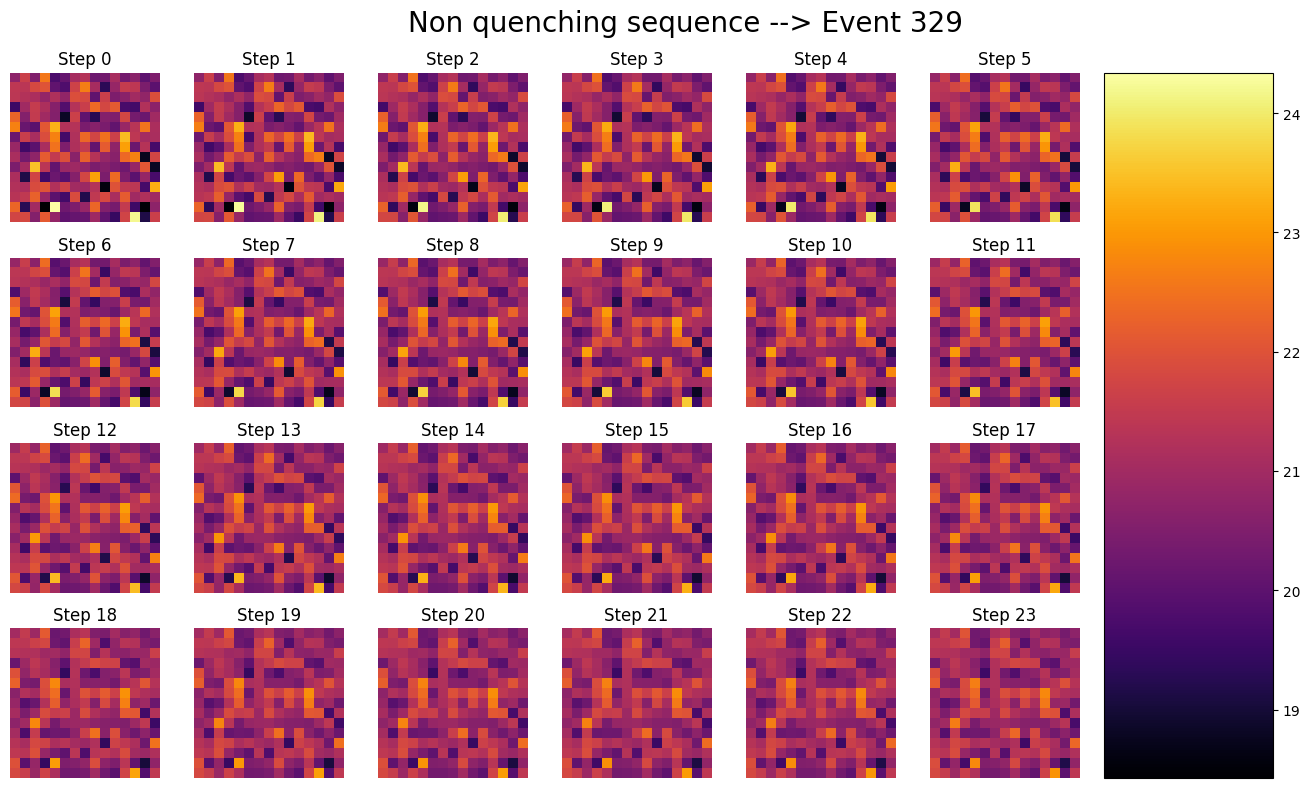

In [4]:
# -----------------Let's plot a non quenching sequence-------------------

idx = np.random.choice(np.where(labels == 0)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Non quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()



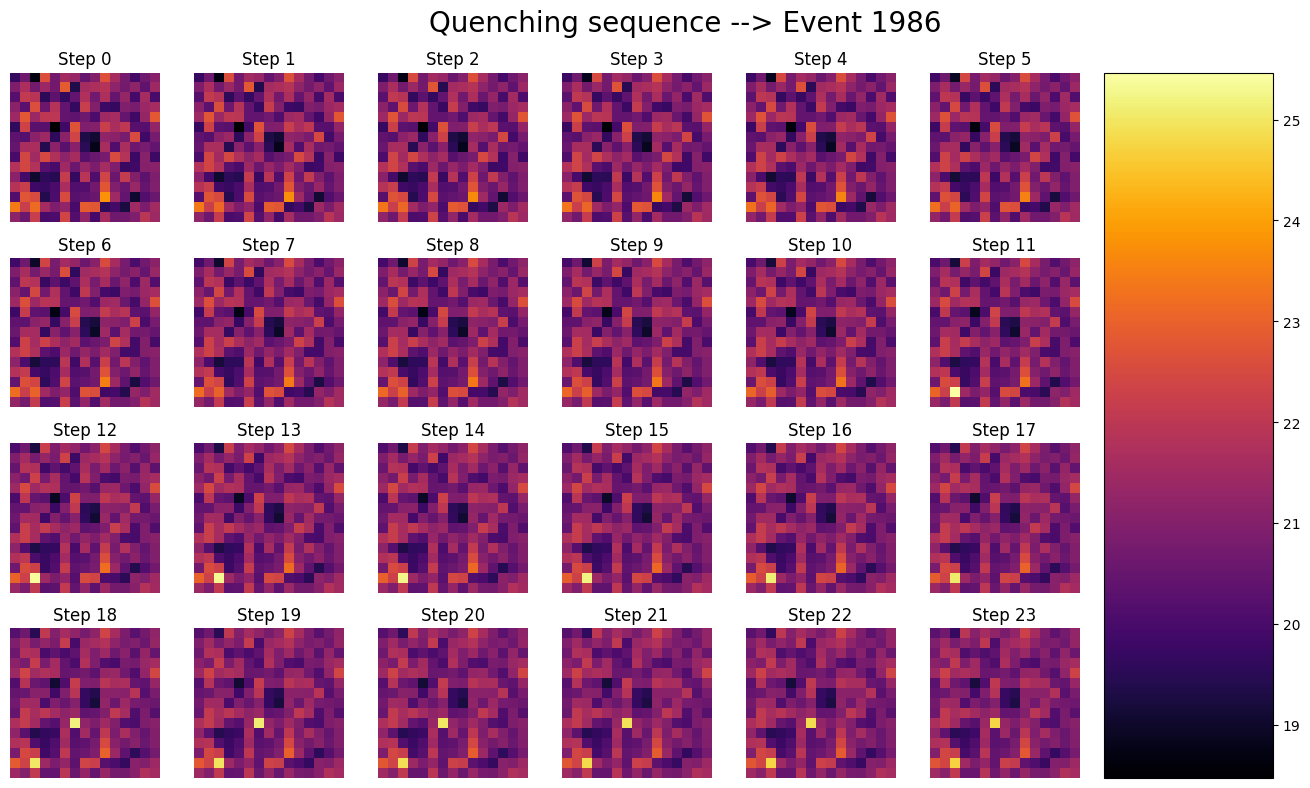

In [5]:
# -----------------Let's plot a quenching sequence-------------------

idx = np.random.choice(np.where(labels == 1)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()


# TASK 1: Identify if a sequence has quanches 

In [385]:
import dgl
import torch

# Let's create a graph for each sequence where each node is an image of the sequence
graphs = []

#let's first reshape the dataPost to have the shape (n_sequences, n_steps, 15*15)
dataPost = dataPost.reshape(dataPost.shape[0], dataPost.shape[1], -1)
print(f"Reshaped dataPost shape: {dataPost.shape}")

for i in range(dataPost.shape[0]):
    g = dgl.DGLGraph()
    g.add_nodes(dataPost.shape[1]) # Adding a node for each step of the sequence
    g.ndata['x'] = torch.tensor(dataPost[i], dtype=torch.float32) # Adding the features to each node
    # Adding edges fully connecting the nodes 
    src, dst = [], []
    for j in range(dataPost.shape[1]):
        for k in range(dataPost.shape[1]):
            if j != k:
                src.append(j)
                dst.append(k)
    g.add_edges(src, dst)
    graphs.append(g)



    

#let's now normalize the features wrt the max value for each sequence
max_values = np.array([item.max() for item in dataPost])
for i in range(len(graphs)):
    graphs[i].ndata['x'] /= max_values[i]



Reshaped dataPost shape: (3000, 24, 225)


/home/mdandrea/personalEnv/conda/envs/mlEnv/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


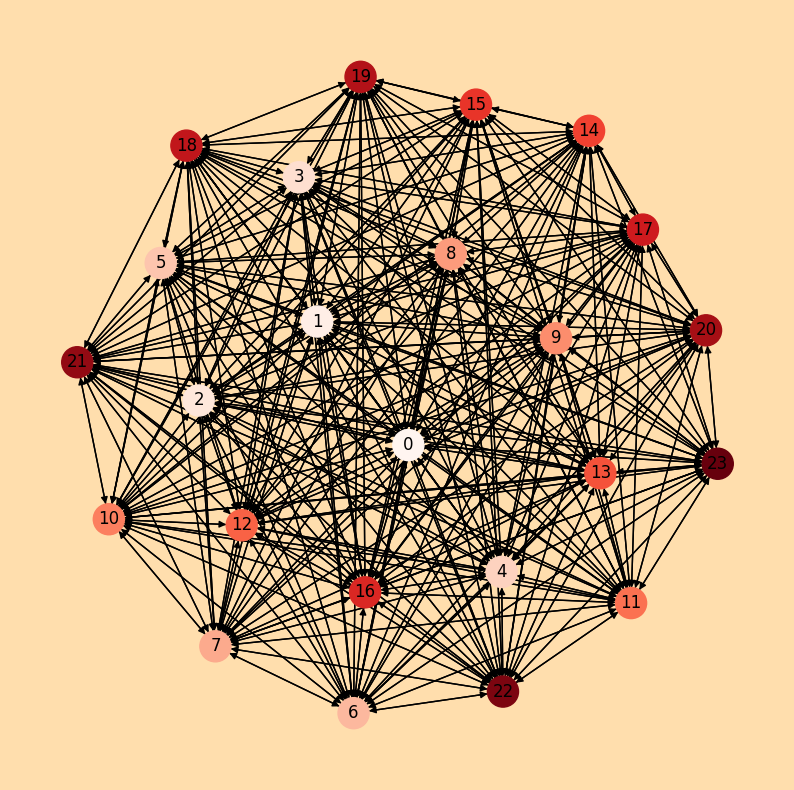

In [388]:
#Visualizing the graph of a sequence
import networkx as nx
import matplotlib.pyplot as plt

idx = np.random.choice(np.arange(len(graphs)))
G = graphs[idx].to_networkx()
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G, pos, node_color=range(dataPost.shape[1]), cmap=plt.cm.Reds, node_size=500, with_labels=True)
ax.set_facecolor('navajowhite')
ax.axis('off')
fig.set_facecolor('navajowhite')
plt.show()


### DataLoader

In [403]:
#let's define a data loader for the dataset
from dgl.data import DGLDataset
from torch.utils.data.sampler import WeightedRandomSampler
from dgl.dataloading import GraphDataLoader
import dgl.data
import numpy as np

class GraphDataset(DGLDataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
        super().__init__(name='my_graph_dataset')

    def process(self):
        # Here you can preprocess your graphs and labels if needed
        pass

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


labelsTensor = [torch.tensor(label) for label in labels]

dataset = GraphDataset(graphs, labelsTensor)
print(f"Dataset length: {len(dataset)}")


#let's split the dataset in training and validation and test

n_Graphs = len(dataset)
n_train = int(n_Graphs * 0.8)
n_val = int(n_Graphs * 0.1)
n_test = n_Graphs - n_train - n_val

indices = torch.randperm(n_Graphs)
train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

# Create subsets of the dataset
train_subset = torch.utils.data.Subset(dataset, train_idx)
val_subset = torch.utils.data.Subset(dataset, val_idx)
test_subset = torch.utils.data.Subset(dataset, test_idx)


# We should create a weighted sampler to balance the classes
weights = 1 / np.bincount(labelsTensor)
weights /= weights.sum()
print(f"Class weights: {weights}")
weightsTensor = weights[labelsTensor]
print(f"Weighted labels: {weightsTensor}")
print(f"weightsTensor[train_idx]: {weightsTensor[train_idx][:30]}")



train_sampler = WeightedRandomSampler(weightsTensor[train_idx], len(train_idx), replacement=True)
val_sampler = WeightedRandomSampler(weightsTensor[val_idx], len(val_idx), replacement=True)
test_sampler = WeightedRandomSampler(weightsTensor[test_idx], len(test_idx), replacement=True)


print("\n#---------------TRAININGSET-----------------#")
print(f"Train sampler number of events: {len(train_sampler)}")
labels_train = labels[train_idx]
labels_train = labels_train[list(train_sampler)]
print(f"labels_train -> {labels_train[:30]}")
n_Unquench = len(labels_train[labels_train == 0])
n_Quench = len(labels_train[labels_train == 1])
print(f"Percentage of quenching events in the training set: {n_Quench / len(labels_train) * 100:.2f}%")
print(f"Percentage of non quenching events in the training set: {n_Unquench / len(labels_train) * 100:.2f}%")
print("#-----------------------------------------#\n")

print("\n#---------------VALIDATIONSET-----------------#")
print(f"Validation sampler number of events: {len(val_sampler)}")
labels_val = labels[val_idx]
labels_val = labels_val[list(val_sampler)]
n_Unquench = len(labels_val[labels_val == 0])
n_Quench = len(labels_val[labels_val == 1])
print(f"Percentage of quenching events in the validation set: {n_Quench / len(labels_val) * 100:.2f}%")
print(f"Percentage of non quenching events in the validation set: {n_Unquench / len(labels_val) * 100:.2f}%")
print("#-----------------------------------------#\n")

print("\n#---------------TESTSET-----------------#")
print(f"Test sampler number of events: {len(test_sampler)}")
labels_test = labels[test_idx]
labels_test = labels_test[list(test_sampler)]
n_Unquench = len(labels_test[labels_test == 0])
n_Quench = len(labels_test[labels_test == 1])
print(f"Percentage of quenching events in the test set: {n_Quench / len(labels_test) * 100:.2f}%")
print(f"Percentage of non quenching events in the test set: {n_Unquench / len(labels_test) * 100:.2f}%")
print("#-----------------------------------------#\n")

# Creating the data loaders
batchSize = 3

print(train_idx)

train_loader = GraphDataLoader(train_subset, sampler=train_sampler, batch_size=batchSize, drop_last=False)
val_loader = GraphDataLoader(val_subset, sampler=val_sampler, batch_size=batchSize, drop_last=False)
test_loader = GraphDataLoader(test_subset, sampler=test_sampler, batch_size=batchSize, drop_last=False)




# Let's check the data loader
print("\n#---------------Checking the data loader-----------------#")
it = iter(train_loader)
batch = next(it)
print(f"Batch data: {batch[0]}")
print(f"Batch labels: {batch[1]}")
print("#-------------------------------------------------------#\n")


Dataset length: 3000
Class weights: [0.1 0.9]
Weighted labels: [0.1 0.1 0.1 ... 0.1 0.1 0.1]
weightsTensor[train_idx]: [0.1 0.1 0.1 0.9 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.9 0.1 0.1 0.9
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

#---------------TRAININGSET-----------------#
Train sampler number of events: 2400
labels_train -> [1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0]
Percentage of quenching events in the training set: 50.75%
Percentage of non quenching events in the training set: 49.25%
#-----------------------------------------#


#---------------VALIDATIONSET-----------------#
Validation sampler number of events: 300
Percentage of quenching events in the validation set: 50.33%
Percentage of non quenching events in the validation set: 49.67%
#-----------------------------------------#


#---------------TESTSET-----------------#
Test sampler number of events: 300
Percentage of quenching events in the test set: 54.00%
Percentage of non quenching events 

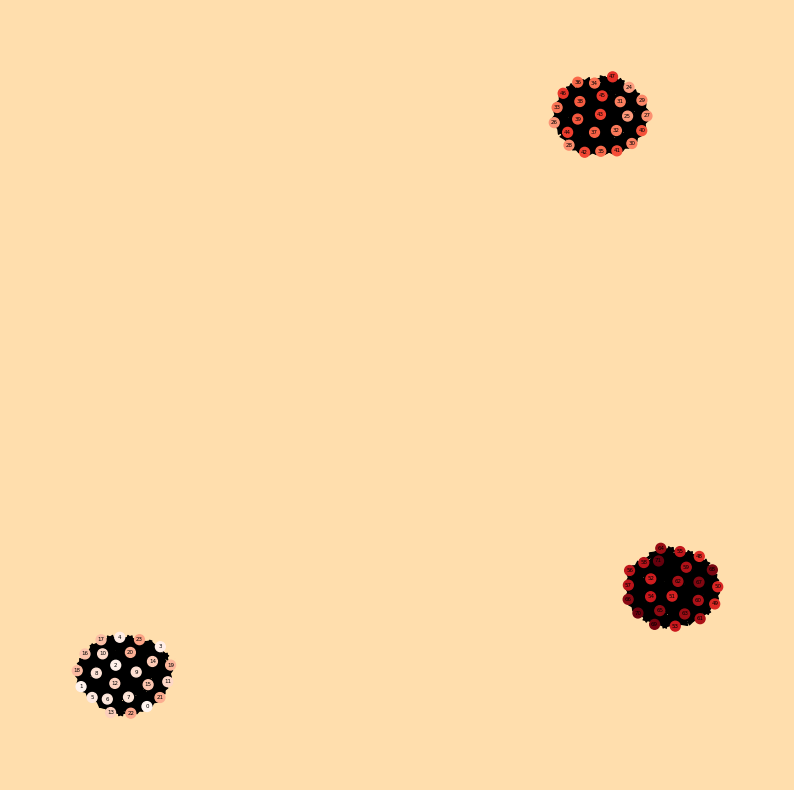

In [409]:
#let's plot the first batch of the training set
import networkx as nx
import matplotlib.pyplot as plt

G = batch[0].to_networkx()
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G, pos, node_color=range(batch[0].number_of_nodes()), cmap=plt.cm.Reds, node_size=50)
#small node labels
nx.draw_networkx_labels(G, pos, font_size=4)
ax.set_facecolor('navajowhite')
ax.axis('off')
fig.set_facecolor('navajowhite')
plt.show()


### loss and models definition

In [390]:
# Define the loss function
import torch.nn.functional as F
import torch

def loss_function(pred, label, pos_weight=None, neg_weight=None):
    if pos_weight is not None and neg_weight is not None:
        # Create a weight tensor that assigns different weights to 0s and 1s
        weights = label.float() * pos_weight + (1 - label.float()) * neg_weight
        return F.binary_cross_entropy_with_logits(pred.view(-1), label.float(), weight=weights)
    else:
        return F.binary_cross_entropy_with_logits(pred.view(-1), label.float())

# Define the accuracy function
def accuracy(pred, label):
    pred = (pred > 0.5).long()
    pred = pred.view(-1)
    correct = (pred == label).sum().item()
    return correct / len(label)

# Training function
def train(model, optimizer, data_loader, scheduler=None):
    model.train()
    total_loss = 0
    total_acc = 0
    for batched_graph, labels in data_loader:
        pred = model(batched_graph, batched_graph.ndata['x'])
        #loss = loss_function(pred, labels, pos_weight=torch.tensor([1.0]), neg_weight=torch.tensor([1.0]))
        loss = loss_function(pred, labels)
        acc = accuracy(pred, labels)
        print(f"pred-> {torch.sigmoid(pred.view(-1))}")
        print(f"labels-> {labels}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step(loss)
        total_loss += loss.detach().item()
        total_acc += acc
    print(f"pred-> {torch.sigmoid(pred.view(-1))}")
    print(f"labels-> {labels}")
    return total_loss / len(data_loader), total_acc / len(data_loader)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for batched_graph, labels in data_loader:
            pred = model(batched_graph, batched_graph.ndata['x'])
            #loss = loss_function(pred, labels, pos_weight=torch.tensor([1.0]), neg_weight=torch.tensor([1.0]))
            loss = loss_function(pred, labels)
            acc = accuracy(pred, labels)
            total_loss += loss.detach().item()
            total_acc += acc
    return total_loss / len(data_loader), total_acc / len(data_loader)


#### GCN

In [394]:
# Defining a first simple model
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
from torch.optim.lr_scheduler import ReduceLROnPlateau

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_sizes):
        super(GCN, self).__init__()
        layers = []
        self.layer_labels = []

        # Define Graph Convolutional layers and ReLU activations
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(dglnn.GraphConv(in_feats, hidden_sizes[i]))
            else:
                layers.append(dglnn.GraphConv(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            self.layer_labels.append(f"GCN_{i}")
            self.layer_labels.append("ReLU")

        self.layers = nn.ModuleList(layers)
        self.fc = nn.Linear(hidden_sizes[-1], 1)

    def forward(self, g, x):
        for layer, label in zip(self.layers, self.layer_labels):
            if label[:3] == "GCN":
                x = layer(g, x)
            else:
                x = layer(x)
        g.ndata['h'] = x
        hg = dgl.mean_nodes(g, 'h')
        return self.fc(hg)

# Create the model with given dimensions
hidden_sizes = [128, 64, 32, 16, 8]
model = GCN(15*15, hidden_sizes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=500, verbose=False, min_lr=1e-6)


In [395]:
# Training the model
num_epochs = 200
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, scheduler)
    val_loss, val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #print the lr
    print(f"lr-> {optimizer.param_groups[0]['lr']}")
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    

pred-> tensor([0.5248, 0.5253, 0.5276, 0.5255, 0.5251, 0.5240, 0.5260, 0.5243, 0.5239,
        0.5246, 0.5240, 0.5272, 0.5272, 0.5248, 0.5238, 0.5249, 0.5261, 0.5243,
        0.5259, 0.5263], grad_fn=<SigmoidBackward0>)
labels-> tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1])
lr-> 0.001
Epoch 1/200 -> Train Loss: 0.6917, Train Acc: 0.4779, Val Loss: 0.6898, Val Acc: 0.4700
pred-> tensor([0.5090, 0.5083, 0.5126, 0.5092, 0.5098, 0.5105, 0.5117, 0.5093, 0.5103,
        0.5091, 0.5088, 0.5112, 0.5090, 0.5100, 0.5121, 0.5092, 0.5096, 0.5105,
        0.5110, 0.5116], grad_fn=<SigmoidBackward0>)
labels-> tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1])
lr-> 0.001
Epoch 2/200 -> Train Loss: 0.6907, Train Acc: 0.4917, Val Loss: 0.6893, Val Acc: 0.4667
pred-> tensor([0.4644, 0.4656, 0.4664, 0.4623, 0.4665, 0.4616, 0.4727, 0.4709, 0.4613,
        0.4695, 0.4674, 0.4625, 0.4608, 0.4623, 0.4692, 0.4720, 0.4685, 0.4629,
        0.4627, 0.4649], grad_fn=<Sigmo

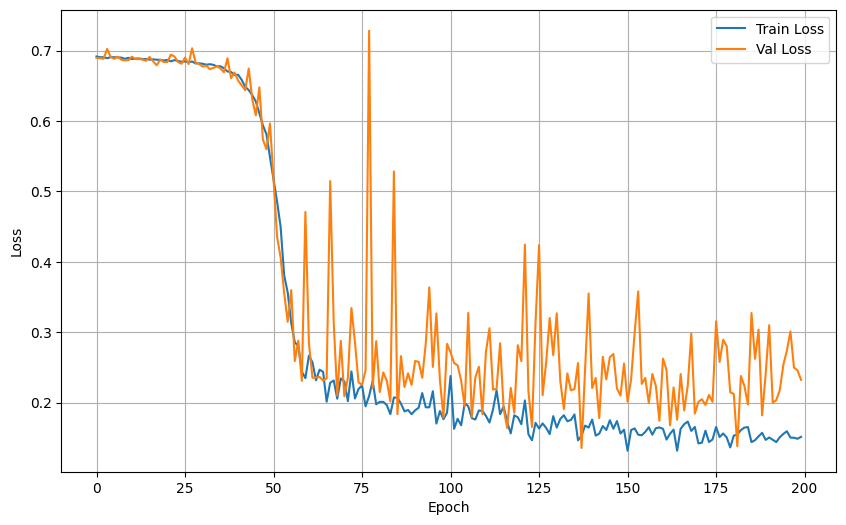

In [396]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#### GAT

In [397]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
from dgl.nn import GATConv, GlobalAttentionPooling

# Definizione della MLP per il mapping delle node features
class MLP(nn.Module):
    def __init__(self, in_feats, hiddenSizes, MLP_out=8):
        super(MLP, self).__init__()
        layers = []
        for hidden_size in hiddenSizes:
            layers.append(nn.Linear(in_feats, hidden_size))
            layers.append(nn.ReLU())
            in_feats = hidden_size
        layers.append(nn.Linear(in_feats, MLP_out))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Definizione della GNN con meccanismo di attenzione
class GNN(nn.Module):
    def __init__(self, in_feats, hiddenSizes, MLP_out, num_heads=4):
        super(GNN, self).__init__()
        self.mlp = MLP(in_feats, hiddenSizes, MLP_out)
        self.gat1 = GATConv(MLP_out, 4, num_heads=num_heads, activation=F.elu)
        gate_nn = nn.Linear(4 * num_heads, 1)  # Aggiornato per corrispondere alla dimensione dell'output di gat1
        self.gap = GlobalAttentionPooling(gate_nn)
        self.LinearClassify = nn.Linear(4 * num_heads, 1)  # Aggiornato per corrispondere alla dimensione dell'output di gat1

    def forward(self, g, features):
        # Step 1: MLP per mappare le node features
        updated_features = self.mlp(features)
        #print(f"Updated features shape: {updated_features.shape}")
        
        # Step 2: Message passing con meccanismo di attenzione
        g.ndata['h'] = updated_features
        h = self.gat1(g, g.ndata['h']).flatten(1)
        #print(f"Features after GAT1: {h.shape}")
        
        # Step 3: Global Attention Pooling
        hg = self.gap(g, h)
        #print(f"Global features: {hg.shape}")

        # Step 4: Classificazione
        return self.LinearClassify(hg)

# Creazione del modello con le dimensioni date
hiddenSizes = [64, 32, 16]
MLP_out = 8
model = GNN(15*15, hiddenSizes, MLP_out)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=500, verbose=False, min_lr=1e-6)


In [398]:
# Training the model
num_epochs = 300
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, scheduler)
    val_loss, val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #print the lr
    print(f"lr-> {optimizer.param_groups[0]['lr']}")
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    

pred-> tensor([0.5089, 0.5076, 0.5097, 0.5081, 0.5101, 0.5080, 0.5092, 0.5096, 0.5103,
        0.5085, 0.5098, 0.5070, 0.5086, 0.5091, 0.5093, 0.5081, 0.5087, 0.5078,
        0.5095, 0.5077], grad_fn=<SigmoidBackward0>)
labels-> tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0])
lr-> 0.001
Epoch 1/300 -> Train Loss: 0.6935, Train Acc: 0.4933, Val Loss: 0.6916, Val Acc: 0.4967
pred-> tensor([0.5237, 0.5252, 0.5235, 0.5232, 0.5256, 0.5247, 0.5243, 0.5232, 0.5233,
        0.5229, 0.5250, 0.5229, 0.5230, 0.5253, 0.5236, 0.5241, 0.5228, 0.5245,
        0.5242, 0.5245], grad_fn=<SigmoidBackward0>)
labels-> tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1])
lr-> 0.001
Epoch 2/300 -> Train Loss: 0.6922, Train Acc: 0.4817, Val Loss: 0.6933, Val Acc: 0.5033
pred-> tensor([0.4828, 0.4859, 0.4770, 0.4813, 0.4804, 0.4784, 0.4791, 0.4900, 0.4777,
        0.4819, 0.4784, 0.4851, 0.4780, 0.4776, 0.4843, 0.4837, 0.4821, 0.4773,
        0.4864, 0.4837], grad_fn=<Sigmo

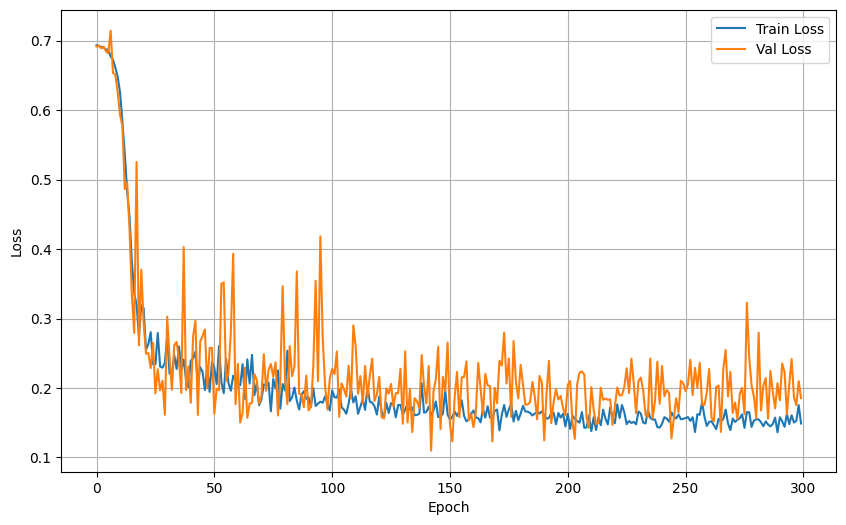

In [399]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
